In [1]:
import os
import shutil
import random
from pathlib import Path

In [2]:
!wget "https://drive.usercontent.google.com/download?id=1YMlfMalleO11EQM9DCpz-rmFsAdvRMPt&export=download&authuser=0&confirm=t&uuid=c24ffb34-fa9b-47ab-bee9-d04f60d15a1d&at=AENtkXYQUhLcbm4sgo7687PqTZD8:1732802044190" -O trash_data.zip


--2024-11-28 21:24:37--  https://drive.usercontent.google.com/download?id=1YMlfMalleO11EQM9DCpz-rmFsAdvRMPt&export=download&authuser=0&confirm=t&uuid=c24ffb34-fa9b-47ab-bee9-d04f60d15a1d&at=AENtkXYQUhLcbm4sgo7687PqTZD8:1732802044190
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.194.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 437243053 (417M) [application/octet-stream]
Saving to: ‘trash_data.zip’

trash_data.zip      100%[===================>] 416.99M  34.1MB/s    in 5.0s    

2024-11-28 21:24:44 (82.7 MB/s) - ‘trash_data.zip’ saved [437243053/437243053]



In [3]:
!unzip -o -q trash_data.zip -d data

In [4]:
data_dir = './data/data'
output_dir = './split_data'

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [5]:
# Buat folder untuk split dataset
Path(output_dir).mkdir(parents=True, exist_ok=True)
for split in ['train', 'val', 'test']:
    (Path(output_dir) / split).mkdir(parents=True, exist_ok=True)

In [6]:
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)  # misal ./data/ada_class
    if not os.path.isdir(class_dir):
        continue

    # Buat folder untuk masing-masing class di train, val, dan test
    for split in ['train', 'val', 'test']:
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

    # Dapatkan semua file gambar dalam folder class
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    random.shuffle(images)

    # Tentukan jumlah data untuk setiap split
    train_count = int(len(images) * train_ratio)
    val_count = int(len(images) * val_ratio)
    test_count = len(images) - train_count - val_count

    # Bagi dataset
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Salin gambar ke folder split masing-masing
    for img in train_images:
        shutil.copy(img, os.path.join(output_dir, 'train', class_name))
    for img in val_images:
        shutil.copy(img, os.path.join(output_dir, 'val', class_name))
    for img in test_images:
        shutil.copy(img, os.path.join(output_dir, 'test', class_name))

print("Dataset berhasil dibagi!")

Dataset berhasil dibagi!


In [7]:
import tensorflow as tf

In [8]:
data_dir = './split_data'

# Parameter dataset
image_size = (150, 150)
batch_size = 32

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/train',
    labels='inferred',
    label_mode='categorical',  # Menggunakan one-hot encoding
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/val',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False  # Tidak perlu diacak
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/test',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False  # Tidak perlu diacak
)

# Periksa struktur dataset
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Found 18917 files belonging to 22 classes.
Found 2355 files belonging to 22 classes.
Found 2385 files belonging to 22 classes.
Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 22), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 22), dtype=tf.float32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 22), dtype=tf.float32, name=None))>


In [10]:
train_dataset_final = train_dataset.cache().shuffle(
    1000,
    reshuffle_each_iteration=True
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset_final = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset_final = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [12]:
models = tf.keras.models
layers = tf.keras.layers

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),

    # Augmentasi yang lebih agresif
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2, fill_mode="nearest"),
    tf.keras.layers.RandomZoom(0.2, fill_mode="nearest"),
    # tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
    # tf.keras.layers.RandomBrightness(0.2),
    # tf.keras.layers.RandomContrast(0.2),

    tf.keras.layers.Rescaling(1./255),
    # # tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    # tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    # tf.keras.layers.BatchNormalization()
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    # tf.keras.layers.Conv2D(512, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    # Dense layers dengan regularisasi yang lebih kuat
    tf.keras.layers.Dense(512, activation="relu"),

    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation('relu'),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(22, activation='softmax')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 22)                  │          11,286 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,044,950 (72.65 MB)

 Trainable params: 19,044,950 (72.65 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 3e-4 * 10**(epoch / 20))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

class PrintLearningRate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Learning rate at epoch {epoch + 1}: {lr}")

In [26]:
history = model.fit(
    train_dataset_final,
    validation_data=val_dataset_final,
    epochs=10,
    verbose=2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
592/592 - 24s - 40ms/step - accuracy: 0.4812 - loss: 1.7343 - val_accuracy: 0.4327 - val_loss: 1.9630 - learning_rate: 2.0000e-04
Epoch 2/10
592/592 - 22s - 37ms/step - accuracy: 0.4897 - loss: 1.7057 - val_accuracy: 0.4599 - val_loss: 1.8886 - learning_rate: 2.2440e-04
Epoch 3/10
592/592 - 41s - 69ms/step - accuracy: 0.5008 - loss: 1.6658 - val_accuracy: 0.4306 - val_loss: 2.0205 - learning_rate: 2.5179e-04
Epoch 4/10
592/592 - 41s - 69ms/step - accuracy: 0.5090 - loss: 1.6452 - val_accuracy: 0.4815 - val_loss: 1.7899 - learning_rate: 2.8251e-04
Epoch 5/10
592/592 - 40s - 68ms/step - accuracy: 0.5164 - loss: 1.6259 - val_accuracy: 0.4777 - val_loss: 1.8201 - learning_rate: 3.1698e-04
Epoch 6/10
592/592 - 21s - 36ms/step - accuracy: 0.5213 - loss: 1.5999 - val_accuracy: 0.4539 - val_loss: 1.8979 - learning_rate: 3.5566e-04
Epoch 7/10
592/592 - 21s - 36ms/step - accuracy: 0.5215 - loss: 1.5931 - val_accuracy: 0.4692 - val_loss: 1.8683 - learning_rate: 3.9905e-04
Epoch 8/10
59

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print("Accuracy", accuracy)

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4312 - loss: 1.9770
Accuracy 0.44570231437683105


In [21]:
import matplotlib.pyplot as plt

In [22]:
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
  ax1.plot(epochs_range, acc, label='Training Accuracy')
  ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.set_title('Training and Validation Accuracy')
  ax1.legend()

  ax2.plot(epochs_range, loss, label='Training Loss')
  ax2.plot(epochs_range, val_loss, label='Validation Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.set_title('Training and Validation Loss')
  ax2.legend()

  plt.tight_layout()
  plt.show()

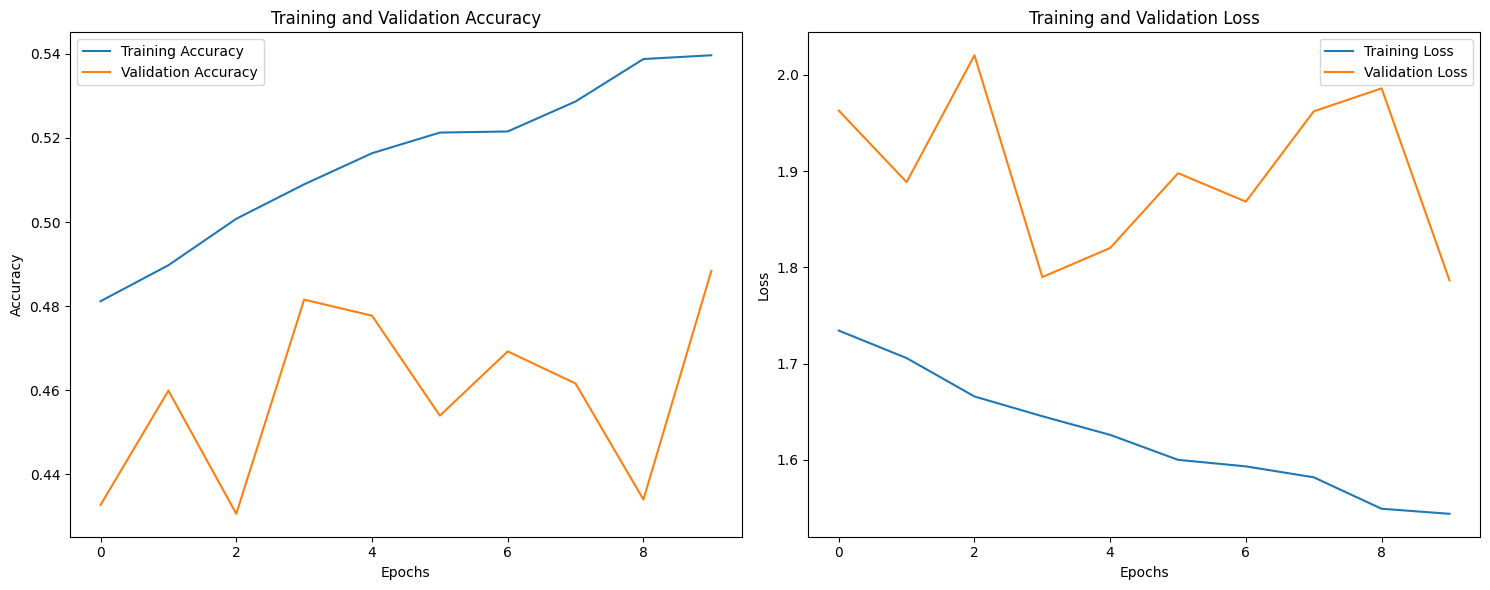

In [27]:
plot_loss_acc(history)

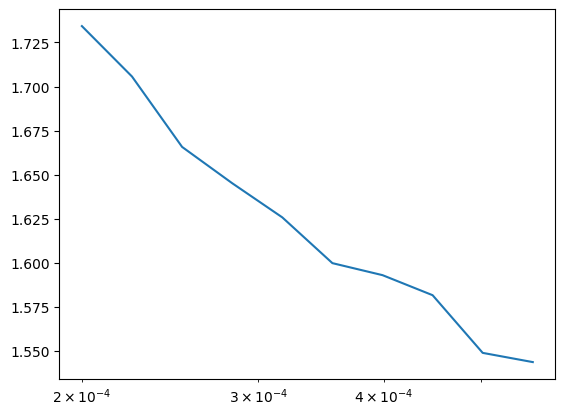

In [28]:
plt.semilogx(history.history['learning_rate'], history.history['loss'])